# Evaluation of the polymorphic Gompertzian model for advanced cancer on in vitro data

This code includes fitting of the polymorphic Gompertzian model, developed by Viossat and Noble (https://doi.org/10.1038/s41559-021-01428-w) to the in vitro data of dynamics od sensitive and resistant cancer cells. The fitting is performed with and witjout optimization of initial population sizes. Distributions of parameter and errors across experimental conditions are visualized. 

In [1]:
#Import required packages
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from matplotlib import ticker
log = math.log
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from scipy import stats

In [2]:
# When running the code for the first time
#pip install gekko

In [2]:
from gekko import GEKKO

# Data

Data is taken from Kaznatcheev et al. (https://doi.org/10.1038/s41559-018-0768-z)

In [3]:
#proportion of parental cells
propP = np.array([[1,1,1,1,1,1,0.9,0.9,0.9,0.9,0.9,0.9,0.4,0.4,0.4,0.4,0.4,0.4,0,0,0,np.NaN],
                  [1,1,1,1,1,1,0.9,0.9,0.9,0.9,0.9,0.9,0.4,0.4,0.4,0.4,0.4,0.4,0,0,0,np.NaN],
                  [1,1,1,1,1,1,0.9,0.9,0.9,0.9,0.9,0.9,0.4,0.4,0.4,0.4,0.4,0.4,0,0,0,np.NaN],
                  [1,1,1,1,1,1,0.9,0.9,0.9,0.9,0.9,0.9,0.4,0.4,0.4,0.4,0.4,0.4,0,0,0,np.NaN],
                  [0.975,0.975,0.975,0.975,0.975,0.975,0.8,0.8,0.8,0.8,0.8,0.8,0.2,0.2,0.2,0.2,0.2,0.2,0,0,0,np.NaN],
                  [0.975,0.975,0.975,0.975,0.975,0.975,0.8,0.8,0.8,0.8,0.8,0.8,0.2,0.2,0.2,0.2,0.2,0.2,0,0,0,np.NaN],
                  [0.975,0.975,0.975,0.975,0.975,0.975,0.8,0.8,0.8,0.8,0.8,0.8,0.2,0.2,0.2,0.2,0.2,0.2,0,0,0,np.NaN],
                  [0.975,0.975,0.975,0.975,0.975,0.975,0.8,0.8,0.8,0.8,0.8,0.8,0.2,0.2,0.2,0.2,0.2,0.2,0,0,0,np.NaN],
                  [0.95,0.95,0.95,0.95,0.95,0.95,0.6,0.6,0.6,0.6,0.6,0.6,0.1,0.1,0.1,0.1,0.1,0.1,np.NaN,np.NaN,np.NaN,np.NaN],
                  [0.95,0.95,0.95,0.95,0.95,0.95,0.6,0.6,0.6,0.6,0.6,0.6,0.1,0.1,0.1,0.1,0.1,0.1,np.NaN,np.NaN,np.NaN,np.NaN],
                  [0.95,0.95,0.95,0.95,0.95,0.95,0.6,0.6,0.6,0.6,0.6,0.6,0.1,0.1,0.1,0.1,0.1,0.1,0.025,0.025,0.025,np.NaN],
                  [0.95,0.95,0.95,0.95,0.95,0.95,0.6,0.6,0.6,0.6,0.6,0.6,0.1,0.1,0.1,0.1,0.1,0.1,0.025,0.025,0.025,np.NaN],
                  [0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025,np.NaN],
                  [0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025,np.NaN]])

#is drug present (1) or not (0)?
drugV = np.array([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                  [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
                  [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
                  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                  [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
                  [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
                  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                  [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0],
                  [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,1],
                  [0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,1],
                  [0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,1]
                 ])

#co-cultured with (1) or without (0) fibroblasts?
fibroV = np.array([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],
                   [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],
                   [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],
                   [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],
                   [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],
                   [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],
                   [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,1],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1],
                   [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
                  ])

In [11]:
#Load processed data from files
os.chdir('/Users/Arina/Desktop/Master Thesis/Codes/Data/')
def LoadPlate(rootDir):
    red_all = np.load('red_all.npy')
    
    green_all = np.load('green_all.npy')
    time_all = np.load('time_all.npy')
    
    return red_all, green_all, time_all

rlanp_t, glanp_t, time_all = LoadPlate('..')

In [12]:
#use this to focus on particular parts of growth phase.
t_min = 0
t_max = 30

#time points
time = np.array(range(np.shape(glanp_t[:,:,:])[0]))*4

In [13]:
# Function that fits the model to the experimental data
def FindIndParams(time, dataS, dataR, drug, fibro, rho0, K0, gamma0, opt_init_prop = False):
    
    m = GEKKO(remote = False)
    
    # parameters and variables
    m.time = time
    Exp_dataS = m.Param(dataS)
    Exp_dataR = m.Param(dataR)

    # parameter and variable options
    rho = m.FV(value = rho0, lb= 0) 
    K = m.FV(value = K0*max(Exp_dataS[:] + Exp_dataR[:]),
             lb = 0.9*max(Exp_dataS[:] + Exp_dataR[:]))#, ub = np.e**15)
    rho.STATUS = 1# available to optimizer
    K.STATUS = 1 #  to minimize objective
    
    if drug ==1:
        gamma = m.FV(value = gamma0, lb = 0)
        gamma.STATUS = 1
        t = m.Param(value = m.time)
        C = m.Var()
        C = m.if3(t-20, 0, 1)
    else:
        gamma = m.Param(value = 0)
        C = m.Param(value = 0)
    
    if opt_init_prop:
        S = m.CV(dataS, lb = 0, fixed_initial=False)
        R = m.CV(dataR, lb = 0, fixed_initial=False)
        S.FSTATUS = 1
        R.FSTATUS = 1
        m.options.CV_TYPE = 2 
    else:
        S = m.Var(dataS[0], lb = 0)
        R = m.Var(dataR[0], lb = 0)
 
    step = [0 if z<0 else 1 for z in m.time]

    # equations
    m.Equation(S.dt() == rho*(1-gamma*C)*S*m.log(K/(S+R)))
    m.Equation(R.dt() == rho*m.log(K/(S+R))*R)

    # objective
    if ~opt_init_prop:
        m.Minimize((Exp_dataS - S)**2/len(time))
        m.Minimize((Exp_dataR - R)**2/len(time))

    # application options 
    m.options.IMODE = 5 # dynamic estimation
    m.options.NODES = 5   # collocation nodes
    #m.options.EV_TYPE = 2 # linear error (2 for squared)
    MAXITER = 1000
    
    m.solve(disp = False)
    
    error = m.options.OBJFCNVAL
    
    return np.array(S), np.array(R), error, K.value[0], rho.value[0], gamma.value[0]



In [14]:
t_min1 = 3
time1 = np.arange(3,30)*4

K_ind1 = np.zeros((14,22))
rho_ind1 = np.zeros((14,22))
gamma_ind1 = np.zeros((14,22))
S_ind1 = np.zeros((len(time1),14,22))
R_ind1 = np.zeros((len(time1),14,22))

In [15]:
# Fit the model to all wells with varied initil values of parameters

rho0s = np.linspace(0.001, 0.01, 5)
gamma0s = np.linspace(1, 10.5, 5)
for i in range(0, np.shape(glanp_t)[1]):
    for j in range( np.shape(glanp_t)[2]):
        drug = drugV[i,j]
        fibro = fibroV[i,j]
        
        if propP[i,j] in [0.1, 0.2, 0.4, 0.6, 0.8, 0.9]:
            err_min = -1
            for rho0 in rho0s:
                for gamma0 in gamma0s:
                    for K0 in [0.9, 1]:
                        try:
                            S, R, error, K, rho, gamma = FindIndParams(time1, glanp_t[t_min1:t_max, i,j],
                                                               rlanp_t[t_min1:t_max,i,j], drug,
                                                               fibro, rho0, K0, gamma0, opt_init_prop = False)
                            err = mean_squared_error(glanp_t[t_min1:t_max, i,j], S) + mean_squared_error(rlanp_t[t_min1:t_max, i,j], R)
                            if (err < err_min)|(err_min == -1) :
                                S_ind1[:,i, j], R_ind1[:, i, j], K_ind1[i,j], rho_ind1[i,j], gamma_ind1[i,j] = S, R, K, rho, gamma
                                err_min = err
                        except:
                            pass    
            print('j=' + str(j))



j=6
j=7
j=8
j=9
j=10
j=11
j=12
j=13
j=14
j=15
j=16
j=17
j=6
j=7
j=8
j=9
j=10
j=11
j=12
j=13
j=14
j=15
j=16
j=17
j=6
j=7
j=8
j=9
j=10
j=11
j=12
j=13
j=14
j=15
j=16
j=17
j=6
j=7
j=8
j=9
j=10
j=11
j=12
j=13
j=14
j=15
j=16
j=17
j=6
j=7
j=8
j=9
j=10
j=11
j=12
j=13
j=14
j=15
j=16
j=17
j=6
j=7
j=8
j=9
j=10
j=11
j=12
j=13
j=14
j=15
j=16
j=17
j=6
j=7
j=8
j=9
j=10
j=11
j=12
j=13
j=14
j=15
j=16
j=17
j=6
j=7
j=8
j=9
j=10
j=11
j=12
j=13
j=14
j=15
j=16
j=17
j=6
j=7
j=8
j=9
j=10
j=11
j=12
j=13
j=14
j=15
j=16
j=17
j=6
j=7
j=8
j=9
j=10
j=11
j=12
j=13
j=14
j=15
j=16
j=17
j=6
j=7
j=8
j=9
j=10
j=11
j=12
j=13
j=14
j=15
j=16
j=17
j=6
j=7
j=8
j=9
j=10
j=11
j=12
j=13
j=14
j=15
j=16
j=17


In [16]:
#FIT 0 and 1 proportions without noise


rho0s = np.linspace(0.001, 0.01, 5)
gamma0s = np.linspace(1, 10.5, 5)
for i in range(0, np.shape(glanp_t)[1]):
    for j in range( np.shape(glanp_t)[2]):
        drug = drugV[i,j]
        fibro = fibroV[i,j]
        p = propP[i,j]
        
        if p in [0, 1]:
            err_min = -1
            for rho0 in rho0s:
                for gamma0 in gamma0s:
                    for K0 in [0.9, 1]:
                        try:
                            S, R, error, K, rho, gamma = FindIndParams(time1, glanp_t[t_min1:t_max, i,j]*p,
                                                               rlanp_t[t_min1:t_max,i,j]*(1-p), drug*p,
                                                               fibro, rho0, K0, gamma0, opt_init_prop = False)
                            err = mean_squared_error(glanp_t[t_min1:t_max, i,j]*p, S) + mean_squared_error((1-p)*rlanp_t[t_min1:t_max, i,j], R)
                            if (err < err_min)|(err_min == -1) :
                                S_ind1[:,i, j], R_ind1[:, i, j], K_ind1[i,j], rho_ind1[i,j], gamma_ind1[i,j] = S, R, K, rho, gamma
                                err_min = err
                        except:
                            pass    
            print('j=' + str(j))


j=0
j=1
j=2
j=3
j=4
j=5
j=18
j=19
j=20
j=0
j=1
j=2
j=3
j=4
j=5
j=18
j=19
j=20
j=0
j=1
j=2
j=3
j=4
j=5
j=18
j=19
j=20
j=0
j=1
j=2
j=3
j=4
j=5
j=18
j=19
j=20
j=18
j=19
j=20
j=18
j=19
j=20
j=18
j=19
j=20
j=18
j=19
j=20


In [17]:
#Calculate actual proportions of senstive cells at t=12h for all wells
t_min = 3
prop_real = np.zeros((14,22))
for i in range(0, np.shape(glanp_t)[1]):
    for j in range( np.shape(glanp_t)[2]):
        if propP[i,j] in [0, 0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 1]:
            prop_real[i, j] = np.round(glanp_t[t_min, i,j]/(glanp_t[t_min, i,j]+rlanp_t[t_min, i,j]), 3)

In [18]:
# Pick wells for illustrations
# One well from each proportion group ([0, 0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 1])
# in each condition (Drug and CAF presence or adsence).
# Wells in one proportion group are picked in such a way that 
# the difference between intended proportions of sensitive cells and actual proportions is minimal
figure_indxs = np.array([]) 

for prop in [0, 0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 1]:
    for d in [0,1]:
        for f in [0, 1]:
            props_list = np.array([]) 
            indx_list = np.array([])
            for i in range(0, np.shape(glanp_t)[1]):
                for j in range( np.shape(glanp_t)[2]):
                    drug = drugV[i,j]
                    fibro = fibroV[i,j]
        
                    if propP[i,j] == prop:
                        if (fibro == f) & (drug == d):
                            props_list = np.append(props_list, prop_real[i,j])
                            if not len(indx_list):
                                indx_list = np.array([[i,j]]) 
                            else:
                                indx_list = np.append(indx_list, [[i,j]], 0)
            idx = np.abs(props_list - prop).argmin()
            if not len(figure_indxs):
                figure_indxs  = [list(indx_list[idx])]
            else:
                figure_indxs  = np.append(figure_indxs, [list(indx_list[idx])], 0)             
                
                


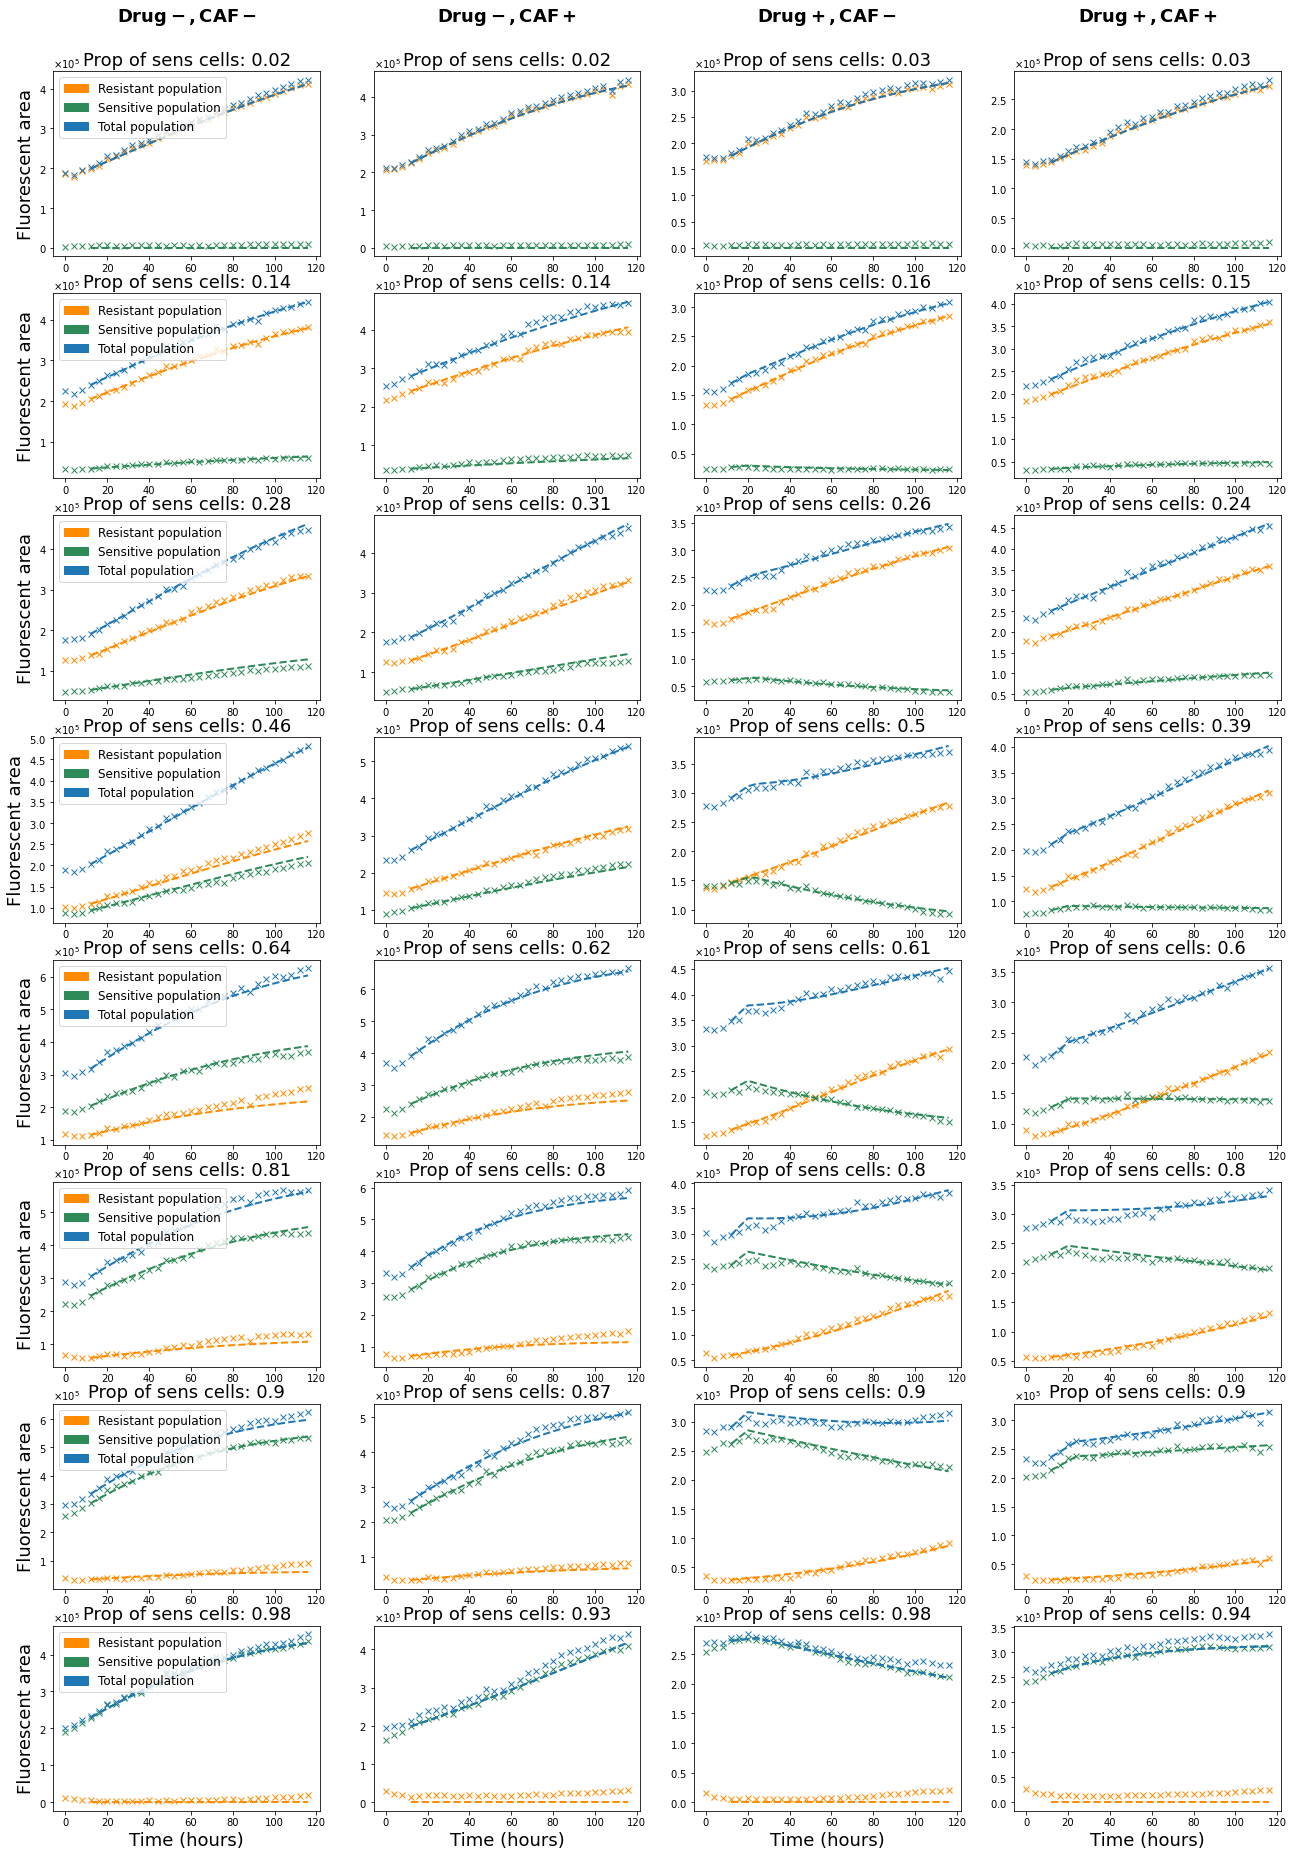

In [19]:
# Visualize dynamics
Rownames = ['Drug-, CAF-', 'Drug-, CAF+',
            'Drug+, CAF-', 'Drug+, CAF+']
t_min = 0

plt.figure(figsize=(22,32))

for k in range(0, 32):
    [i,j] = figure_indxs[k]
    ax = plt.subplot(8,4,k+1)
    ax.plot(time1, R_ind1[:, i,j], lw = 2, color = 'darkorange', linestyle='--', label = 'Resistant population');
    ax.plot(time[t_min:t_max], rlanp_t[t_min:t_max, i,j], color = 'darkorange', marker = 'x',   linestyle = 'none', fillstyle = 'none')
    ax.plot(time1, S_ind1[:, i,j], lw = 2, color = 'seagreen', linestyle='--', label = 'Sensitive population');
    ax.plot(time[t_min:t_max], glanp_t[t_min:t_max, i,j], color = 'seagreen', marker = 'x', linestyle = 'none', fillstyle = 'none')
    ax.plot(time1, R_ind1[:, i,j] + S_ind1[:, i,j] , lw = 2, color = 'tab:blue', linestyle='--', label = 'Total population');
    ax.plot(time[t_min:t_max], rlanp_t[t_min:t_max, i,j] + glanp_t[t_min:t_max, i,j], color = 'tab:blue', marker = 'x', linestyle = 'none', fillstyle = 'none')
    #ax.set_xlabel('Time (hours)')
    if k < 4:
        ax.set_title(r'$\bf{{{'+ Rownames[k]+'}}}$'+'\n\n'+'Prop of sens cells: ' + str(round(glanp_t[t_min1, i,j]/(glanp_t[t_min1, i,j] + rlanp_t[t_min1, i,j]), 2)), size = 18)
    else:
        ax.set_title('Prop of sens cells: ' + str(round(glanp_t[t_min1, i,j]/(glanp_t[t_min1, i,j] + rlanp_t[t_min1, i,j]), 2)), size = 18)
            
    if k >= 28:
        ax.set_xlabel('Time (hours)', size = 18)
    orange = matplotlib.patches.Patch(color='darkorange', label= 'Resistant population')
    blue = matplotlib.patches.Patch(color='tab:blue', label= 'Total population') 
    green = matplotlib.patches.Patch(color='seagreen', label= 'Sensitive population')  
    if (k)%4 == 0:
        ax.legend(handles=[orange, green, blue], loc = 2, fontsize = 12)
        ax.set_ylabel('Fluorescent area', size = 18)
        
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True) 
    formatter.set_powerlimits((-1,1)) 
    ax.yaxis.set_major_formatter(formatter) 
plt.show()

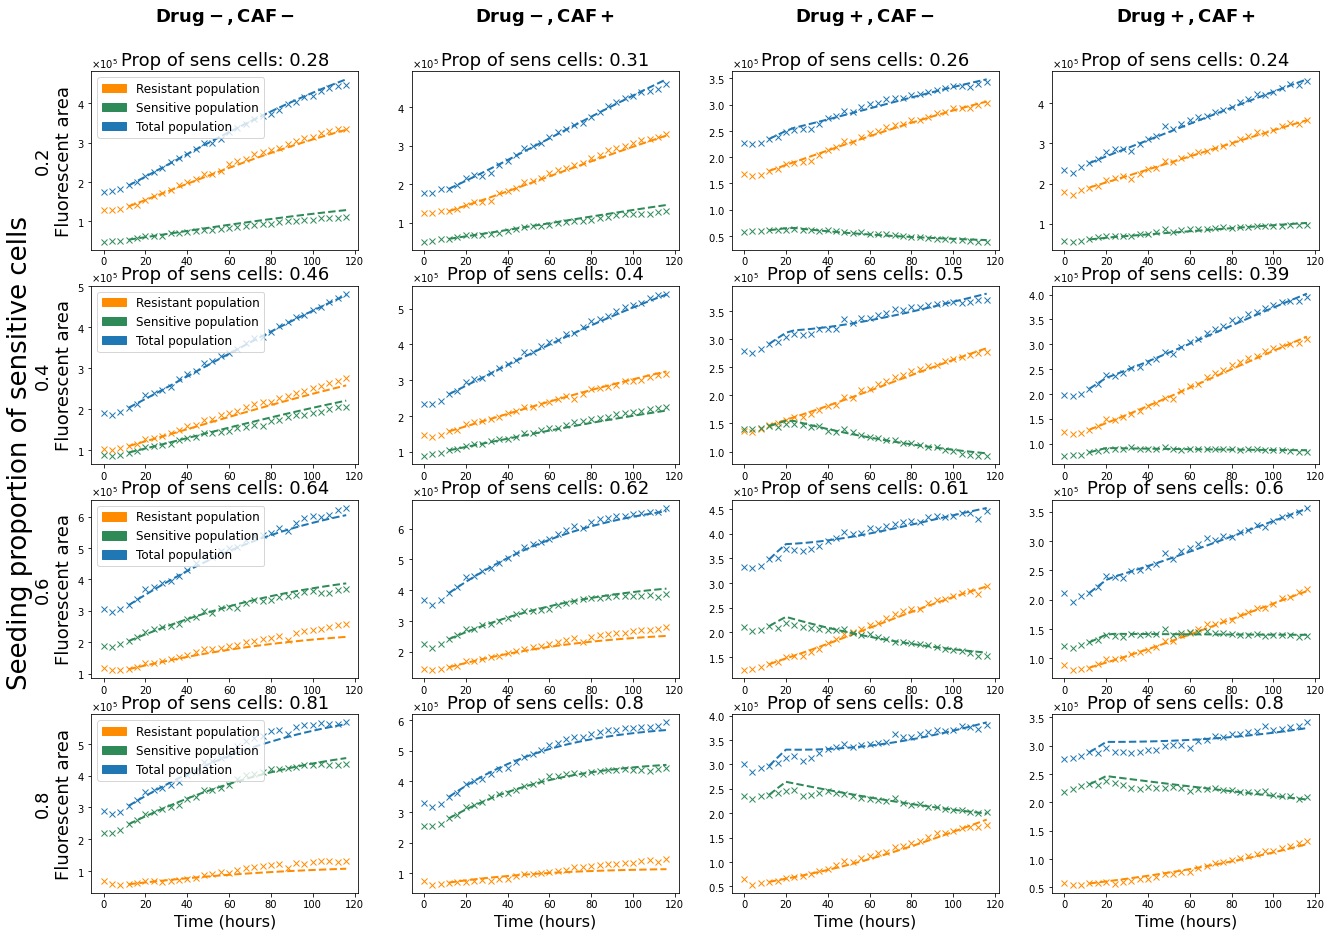

In [36]:
# Visualize dynamics
figure_indxs_upd = figure_indxs[[0,1,2,3, 8, 9, 10, 11, 12,13,14,15,16,17,18,19, 
                                 20, 21, 22,23,28, 29,30, 31]]

Rownames = ['Drug-, CAF-', 'Drug-, CAF+',
            'Drug+, CAF-', 'Drug+, CAF+']
t_min = 0
cm = 1/2.54
fig = plt.figure(figsize=(22, 23))
intended_props = [0, 0.2, 0.4, 0.6, 0.8, 1]

for k in range(4, 20):
    [i,j] = figure_indxs_upd[k]
    ax = plt.subplot(6,4,k+1-4)
    ax.plot(time1, R_ind1[:, i,j], lw = 2, color = 'darkorange', linestyle='--', label = 'Resistant population');
    ax.plot(time[t_min:t_max], rlanp_t[t_min:t_max, i,j], color = 'darkorange', marker = 'x',   linestyle = 'none', fillstyle = 'none')
    ax.plot(time1, S_ind1[:, i,j], lw = 2, color = 'seagreen', linestyle='--', label = 'Sensitive population');
    ax.plot(time[t_min:t_max], glanp_t[t_min:t_max, i,j], color = 'seagreen', marker = 'x', linestyle = 'none', fillstyle = 'none')
    ax.plot(time1, R_ind1[:, i,j] + S_ind1[:, i,j] , lw = 2, color = 'tab:blue', linestyle='--', label = 'Total population');
    ax.plot(time[t_min:t_max], rlanp_t[t_min:t_max, i,j] + glanp_t[t_min:t_max, i,j], color = 'tab:blue', marker = 'x', linestyle = 'none', fillstyle = 'none')
    #ax.set_xlabel('Time (hours)')
    if (k < 8) & (k>3):
        ax.set_title(r'$\bf{{{'+ Rownames[k-4]+'}}}$'+'\n\n'+'Prop of sens cells: ' + str(round(glanp_t[t_min1, i,j]/(glanp_t[t_min1, i,j] + rlanp_t[t_min1, i,j]), 2)), size = 18)
    else:
        ax.set_title('Prop of sens cells: ' + str(round(glanp_t[t_min1, i,j]/(glanp_t[t_min1, i,j] + rlanp_t[t_min1, i,j]), 2)), size = 18)
            
    if k >= 16:
        ax.set_xlabel('Time (hours)', size = 16)
    orange = matplotlib.patches.Patch(color='darkorange', label= 'Resistant population')
    blue = matplotlib.patches.Patch(color='tab:blue', label= 'Total population') 
    green = matplotlib.patches.Patch(color='seagreen', label= 'Sensitive population')  
    if (k)%4 == 0:
        ax.legend(handles=[orange, green, blue], loc = 2, fontsize = 12)
        ax.set_ylabel(str(intended_props[int(k/4)])+'\nFluorescent area', size = 18)
        
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True) 
    formatter.set_powerlimits((-1,1)) 
    ax.yaxis.set_major_formatter(formatter)
    
fig.text(0.08, 0.65, 'Seeding proportion of sensitive cells', va='center',
         ha='center', rotation='vertical', fontsize=26)
#plt.supyabel('Initial proportion of sensitive cells', size = 20)
plt.show()
fig.savefig('/Users/Arina/Desktop/Master Thesis/Figures for article/FIG11.jpg',
           dpi = 500, bbox_inches = "tight")
fig.savefig('/Users/Arina/Desktop/Master Thesis/Figures for PLOS/FIG1.tiff', 
            dpi=600, format="tiff", bbox_inches = "tight")#, pil_kwargs={"compression": "tiff_lzw"})

In [21]:
#Calculate MSE 
props = [ 0.1, 0.2, 0.4, 0.6, 0.8, 0.9]
MSE_S1 = np.zeros((14,22))
MSE_R1 = np.zeros((14,22))
MSE_N1 = np.zeros((14,22))
for i in range(np.shape(glanp_t)[1]):
    for j in range( np.shape(glanp_t)[2]):
        if propP[i,j] in props:
            MSE_S1[i, j] = mean_squared_error(S_ind1[:, i,j], glanp_t[t_min1:t_max, i,j])
            MSE_R1[i, j] = mean_squared_error(R_ind1[:, i,j], rlanp_t[t_min1:t_max, i,j])
            MSE_N1[i, j] = mean_squared_error((S_ind1[:, i,j] + R_ind1[:, i,j]),
                                                 (glanp_t[t_min1:t_max, i,j] + rlanp_t[t_min1:t_max, i,j]))
        elif propP[i,j] in [0,1]:
            p = propP[i,j]
            MSE_S1[i, j] = mean_squared_error(S_ind1[:, i,j], glanp_t[t_min1:t_max, i,j])*p
            MSE_R1[i, j] = mean_squared_error(R_ind1[:, i,j], rlanp_t[t_min1:t_max, i,j])*(1-p)
            MSE_N1[i, j] = mean_squared_error((S_ind1[:, i,j] + R_ind1[:, i,j]),
                                                 (glanp_t[t_min1:t_max, i,j]*p + (1-p)*rlanp_t[t_min1:t_max, i,j]))
                

In [22]:
# Calculate percentage errors 
props = [0.1, 0.2, 0.4, 0.6, 0.8, 0.9]
MAPE_S1 = np.zeros((14,22))
MAPE_R1 = np.zeros((14,22))
MAPE_N1 = np.zeros((14,22))
for i in range(np.shape(glanp_t)[1]):
    for j in range( np.shape(glanp_t)[2]):
        if propP[i,j] in props:
            MAPE_S1[i, j] = mean_absolute_percentage_error(S_ind1[:, i,j], glanp_t[t_min1:t_max, i,j])
            MAPE_R1[i, j] = mean_absolute_percentage_error(R_ind1[:, i,j], rlanp_t[t_min1:t_max, i,j])
            MAPE_N1[i, j] = mean_absolute_percentage_error((S_ind1[:, i,j] + R_ind1[:, i,j]),
                                                 (glanp_t[t_min1:t_max, i,j] + rlanp_t[t_min1:t_max, i,j]))
        if propP[i,j] in [0, 1]:
            p = propP[i,j]
            MAPE_S1[i, j] = mean_absolute_percentage_error(S_ind1[:, i,j], glanp_t[t_min1:t_max, i,j])*p
            MAPE_R1[i, j] = mean_absolute_percentage_error(R_ind1[:, i,j], rlanp_t[t_min1:t_max, i,j])*(1-p)
            MAPE_N1[i, j] = mean_absolute_percentage_error((S_ind1[:, i,j] + R_ind1[:, i,j]),
                                                 (glanp_t[t_min1:t_max, i,j]*p + (1-p)*rlanp_t[t_min1:t_max, i,j]))

# Fit the model with optimization of initial amounts of cells

In [23]:
t_min2 = 3
time2 = np.arange(3,30)*4

K_ind2 = np.zeros((14,22))
rho_ind2 = np.zeros((14,22))
gamma_ind2 = np.zeros((14,22))
S_ind2 = np.zeros((len(time2),14,22))
R_ind2 = np.zeros((len(time2),14,22))

In [20]:
# Fit the model to all wells 
#(initial parameters values were manually picked for each proportion)
for i in range(0, np.shape(glanp_t)[1]):
    for j in range( np.shape(glanp_t)[2]):
        drug = drugV[i,j]
        fibro = fibroV[i,j]
        
        if propP[i,j] in [0.1, 0.2, 0.4, 0.6]:
            K0= 1
            rho0 = 0.001
            gamma0 = 10.5
            
            S_ind2[:,i, j], R_ind2[:, i, j], error, K_ind2[i,j], rho_ind2[i,j], gamma_ind2[i,j] = FindIndParams(time2, glanp_t[t_min2:t_max, i,j], rlanp_t[t_min2:t_max,i,j], drug, fibro, rho0, K0, gamma0, opt_init_prop = True)
            print('j=' + str(j))
            
        if propP[i,j] in [0.8]:
            if (drug == 1) & (fibro == 0):
                K0= 1
                rho0 = 0.002
                gamma0 = 2.5
                S_ind2[:,i, j], R_ind2[:, i, j], error, K_ind2[i,j], rho_ind2[i,j], gamma_ind2[i,j] = FindIndParams(time2, glanp_t[t_min2:t_max, i,j], rlanp_t[t_min2:t_max,i,j], drug, fibro, rho0, K0, gamma0, opt_init_prop = True)
                print('j=' + str(j))
                
            else:
                K0= 1
                rho0 = 0.001
                gamma0 = 10.5
                S_ind2[:,i, j], R_ind2[:, i, j], error, K_ind2[i,j], rho_ind2[i,j], gamma_ind2[i,j] = FindIndParams(time2, glanp_t[t_min2:t_max, i,j], rlanp_t[t_min2:t_max,i,j], drug, fibro, rho0, K0, gamma0, opt_init_prop = True)
                print('j=' + str(j))
                
        if propP[i,j] in [0.9]:
            K0 = 1
            gamma0 = 3.8
            if (drug == 1) & (fibro == 0):
                gamma0 = 3.8
                if (j%2 == 1):
                    if j == 9:
                        rho0 = 0.004
                        S_ind2[:,i, j], R_ind2[:, i, j], error, K_ind2[i,j], rho_ind2[i,j], gamma_ind2[i,j] = FindIndParams(time2, glanp_t[t_min2:t_max, i,j], rlanp_t[t_min2:t_max,i,j], drug, fibro, rho0, K0, gamma0, opt_init_prop = True)
                        print('j=' + str(j))    
                    else:
                        rho0 = 0.002
                        S_ind2[:,i, j], R_ind2[:, i, j], error, K_ind2[i,j], rho_ind2[i,j], gamma_ind2[i,j] = FindIndParams(time2, glanp_t[t_min2:t_max, i,j], rlanp_t[t_min2:t_max,i,j], drug, fibro, rho0, K0, gamma0, opt_init_prop = True)
                        print('j=' + str(j))
                else:
                    rho0 = 0.001
                    S_ind2[:,i, j], R_ind2[:, i, j], error, K_ind2[i,j], rho_ind2[i,j], gamma_ind2[i,j] = FindIndParams(time2, glanp_t[t_min2:t_max, i,j], rlanp_t[t_min2:t_max,i,j], drug, fibro, rho0, K0, gamma0, opt_init_prop = True)
                    print('j=' + str(j))
            else:
                rho0 = 0.001
                S_ind2[:,i, j], R_ind2[:, i, j], error, K_ind2[i,j], rho_ind2[i,j], gamma_ind2[i,j] = FindIndParams(time2, glanp_t[t_min2:t_max, i,j], rlanp_t[t_min2:t_max,i,j], drug, fibro, rho0, K0, gamma0, opt_init_prop = True)
                print('j=' + str(j))
            
        if propP[i,j] in [0]:
            K0 = 1
            rho0 = 0.01
            gamma0 = 10.5
            
            err_min = -1
            for rho0 in [0.01, 0.001]:
                try:
                    S, R, K, rho, gamma = FindIndParams(time2, glanp_t[t_min2:t_max, i,j]*0, rlanp_t[t_min2:t_max,i,j], drug, fibro, rho0, K0, gamma0, opt_init_prop = True)
                    err = mean_squared_error(glanp_t[t_min1:t_max, i,j]*p, S) + mean_squared_error(rlanp_t[t_min1:t_max, i,j]*(1-p), R)
                    if (err < err_min)|(err_min == -1):
                        S_ind2[:,i, j], R_ind2[:, i, j], K_ind2[i,j], rho_ind2[i,j], gamma_ind2[i,j] = S, R, K, rho, gamma
                        err_min = err
                except:
                    pass  
            print('j=' + str(j))
            
        if propP[i,j] in [1]:
            K0 = 1
            if (drug == 1) & (fibro == 1):
                gamma0 = 1.1
                if j == 0:
                    rho0 = 0.001
                    S_ind2[:,i, j], R_ind2[:, i, j], error, K_ind2[i,j], rho_ind2[i,j], gamma_ind2[i,j] = FindIndParams(time2, glanp_t[t_min2:t_max, i,j], rlanp_t[t_min2:t_max,i,j]*0, drug, fibro, rho0, K0, gamma0, opt_init_prop = True)
                    print('j=' + str(j))
                else:
                    rho0 = 0.002
                    S_ind2[:,i, j], R_ind2[:, i, j], error, K_ind2[i,j], rho_ind2[i,j], gamma_ind2[i,j] = FindIndParams(time2, glanp_t[t_min2:t_max, i,j], rlanp_t[t_min2:t_max,i,j]*0, drug, fibro, rho0, K0, gamma0, opt_init_prop = True)
                    print('j=' + str(j)) 
            else:
                rho0 = 0.001
                gamma0 = 4
                S_ind2[:,i, j], R_ind2[:, i, j], error, K_ind2[i,j], rho_ind2[i,j], gamma_ind2[i,j] = FindIndParams(time2, glanp_t[t_min2:t_max, i,j], rlanp_t[t_min2:t_max,i,j]*0, drug, fibro, rho0, K0, gamma0, opt_init_prop = True)
                print('j=' + str(j))
            

j=0
j=1
j=2
j=3
j=4
j=5
j=6
j=7
j=8
j=9
j=10
j=11
j=12
j=13
j=14
j=15
j=16
j=17
j=18
j=19
j=20
j=0
j=1
j=2
j=3
j=4
j=5
j=6
j=7
j=8
j=9
j=10
j=11
j=12
j=13
j=14
j=15
j=16
j=17
j=18
j=19
j=20
j=0
j=1
j=2
j=3
j=4
j=5
j=6
j=7
j=8
j=9
j=10
j=11
j=12
j=13
j=14
j=15
j=16
j=17
j=18
j=19
j=20
j=0
j=1
j=2
j=3
j=4
j=5
j=6
j=7
j=8
j=9
j=10
j=11
j=12
j=13
j=14
j=15
j=16
j=17
j=18
j=19
j=20
j=6
j=7
j=8
j=9
j=10
j=11
j=12
j=13
j=14
j=15
j=16
j=17
j=18
j=19
j=20
j=6
j=7
j=8
j=9
j=10
j=11
j=12
j=13
j=14
j=15
j=16
j=17
j=18
j=19
j=20
j=6
j=7
j=8
j=9
j=10
j=11
j=12
j=13
j=14
j=15
j=16
j=17
j=18
j=19
j=20
j=6
j=7
j=8
j=9
j=10
j=11
j=12
j=13
j=14
j=15
j=16
j=17
j=18
j=19
j=20
j=6
j=7
j=8
j=9
j=10
j=11
j=12
j=13
j=14
j=15
j=16
j=17
j=6
j=7
j=8
j=9
j=10
j=11
j=12
j=13
j=14
j=15
j=16
j=17
j=6
j=7
j=8
j=9
j=10
j=11
j=12
j=13
j=14
j=15
j=16
j=17
j=6
j=7
j=8
j=9
j=10
j=11
j=12
j=13
j=14
j=15
j=16
j=17


In [ ]:
# Fit the model to all wells 
#(initial parameters values were manually picked for each proportion)
for i in range(0, np.shape(glanp_t)[1]):
    for j in range( np.shape(glanp_t)[2]):
        drug = drugV[i,j]
        fibro = fibroV[i,j]
        
        if propP[i,j] in [0.1, 0.2, 0.4, 0.6]:
            K0= 1
            rho0 = 0.001
            gamma0 = 10.5
            
            S_ind2[:,i, j], R_ind2[:, i, j], error, K_ind2[i,j], rho_ind2[i,j], gamma_ind2[i,j] = FindIndParams(time2, glanp_t[t_min2:t_max, i,j], rlanp_t[t_min2:t_max,i,j], drug, fibro, rho0, K0, gamma0, opt_init_prop = True)
            print('j=' + str(j))
            
        if propP[i,j] in [0.8]:
            if (drug == 1) & (fibro == 0):
                K0= 1
                rho0 = 0.002
                gamma0 = 2.5
                S_ind2[:,i, j], R_ind2[:, i, j], error, K_ind2[i,j], rho_ind2[i,j], gamma_ind2[i,j] = FindIndParams(time2, glanp_t[t_min2:t_max, i,j], rlanp_t[t_min2:t_max,i,j], drug, fibro, rho0, K0, gamma0, opt_init_prop = True)
                print('j=' + str(j))
                
            else:
                K0= 1
                rho0 = 0.001
                gamma0 = 10.5
                S_ind2[:,i, j], R_ind2[:, i, j], error, K_ind2[i,j], rho_ind2[i,j], gamma_ind2[i,j] = FindIndParams(time2, glanp_t[t_min2:t_max, i,j], rlanp_t[t_min2:t_max,i,j], drug, fibro, rho0, K0, gamma0, opt_init_prop = True)
                print('j=' + str(j))
                
        if propP[i,j] in [0.9]:
            K0 = 1
            gamma0 = 3.8
            if (drug == 1) & (fibro == 0):
                gamma0 = 3.8
                if (j%2 == 1):
                    if j == 9:
                        rho0 = 0.004
                        S_ind2[:,i, j], R_ind2[:, i, j], error, K_ind2[i,j], rho_ind2[i,j], gamma_ind2[i,j] = FindIndParams(time2, glanp_t[t_min2:t_max, i,j], rlanp_t[t_min2:t_max,i,j], drug, fibro, rho0, K0, gamma0, opt_init_prop = True)
                        print('j=' + str(j))    
                    else:
                        rho0 = 0.002
                        S_ind2[:,i, j], R_ind2[:, i, j], error, K_ind2[i,j], rho_ind2[i,j], gamma_ind2[i,j] = FindIndParams(time2, glanp_t[t_min2:t_max, i,j], rlanp_t[t_min2:t_max,i,j], drug, fibro, rho0, K0, gamma0, opt_init_prop = True)
                        print('j=' + str(j))
                else:
                    rho0 = 0.001
                    S_ind2[:,i, j], R_ind2[:, i, j], error, K_ind2[i,j], rho_ind2[i,j], gamma_ind2[i,j] = FindIndParams(time2, glanp_t[t_min2:t_max, i,j], rlanp_t[t_min2:t_max,i,j], drug, fibro, rho0, K0, gamma0, opt_init_prop = True)
                    print('j=' + str(j))
            else:
                rho0 = 0.001
                S_ind2[:,i, j], R_ind2[:, i, j], error, K_ind2[i,j], rho_ind2[i,j], gamma_ind2[i,j] = FindIndParams(time2, glanp_t[t_min2:t_max, i,j], rlanp_t[t_min2:t_max,i,j], drug, fibro, rho0, K0, gamma0, opt_init_prop = True)
                print('j=' + str(j))
            
        if propP[i,j] in [1]:
            K0 = 1
            if (drug == 1) & (fibro == 1):
                gamma0 = 1.1
                if j == 0:
                    rho0 = 0.001
                    S_ind2[:,i, j], R_ind2[:, i, j], error, K_ind2[i,j], rho_ind2[i,j], gamma_ind2[i,j] = FindIndParams(time2, glanp_t[t_min2:t_max, i,j], rlanp_t[t_min2:t_max,i,j]*0, drug, fibro, rho0, K0, gamma0, opt_init_prop = True)
                    print('j=' + str(j))
                else:
                    rho0 = 0.002
                    S_ind2[:,i, j], R_ind2[:, i, j], error, K_ind2[i,j], rho_ind2[i,j], gamma_ind2[i,j] = FindIndParams(time2, glanp_t[t_min2:t_max, i,j], rlanp_t[t_min2:t_max,i,j]*0, drug, fibro, rho0, K0, gamma0, opt_init_prop = True)
                    print('j=' + str(j)) 
            else:
                rho0 = 0.001
                gamma0 = 4
                S_ind2[:,i, j], R_ind2[:, i, j], error, K_ind2[i,j], rho_ind2[i,j], gamma_ind2[i,j] = FindIndParams(time2, glanp_t[t_min2:t_max, i,j], rlanp_t[t_min2:t_max,i,j]*0, drug, fibro, rho0, K0, gamma0, opt_init_prop = True)
                print('j=' + str(j))
            

In [ ]:
rho0s = np.linspace(0.001, 0.01, 5)
gamma0s = np.linspace(1, 10.5, 5)
for i in range(0, np.shape(glanp_t)[1]):
    for j in range( np.shape(glanp_t)[2]):
        drug = drugV[i,j]
        fibro = fibroV[i,j]
        
        if (propP[i,j] in [0.9]) & (drug == 1):
            err_min = -1
            for rho0 in rho0s:
                for gamma0 in gamma0s:
                    for K0 in [0.9, 1]:
                        try:
                            S, R, error, K, rho, gamma = FindIndParams(time2, glanp_t[t_min2:t_max, i,j],
                                                               rlanp_t[t_min2:t_max,i,j], drug,
                                                               fibro, rho0, K0, gamma0, opt_init_prop = True)
                            err = mean_squared_error(glanp_t[t_min1:t_max, i,j], S) + mean_squared_error(rlanp_t[t_min1:t_max, i,j], R)
                            if (err < err_min)|(err_min == -1) :
                                S_ind2[:,i, j], R_ind2[:, i, j], K_ind2[i,j], rho_ind2[i,j], gamma_ind2[i,j] = S, R, K, rho, gamma
                                err_min = err
                        except:
                            pass    
            print('j=' + str(j))

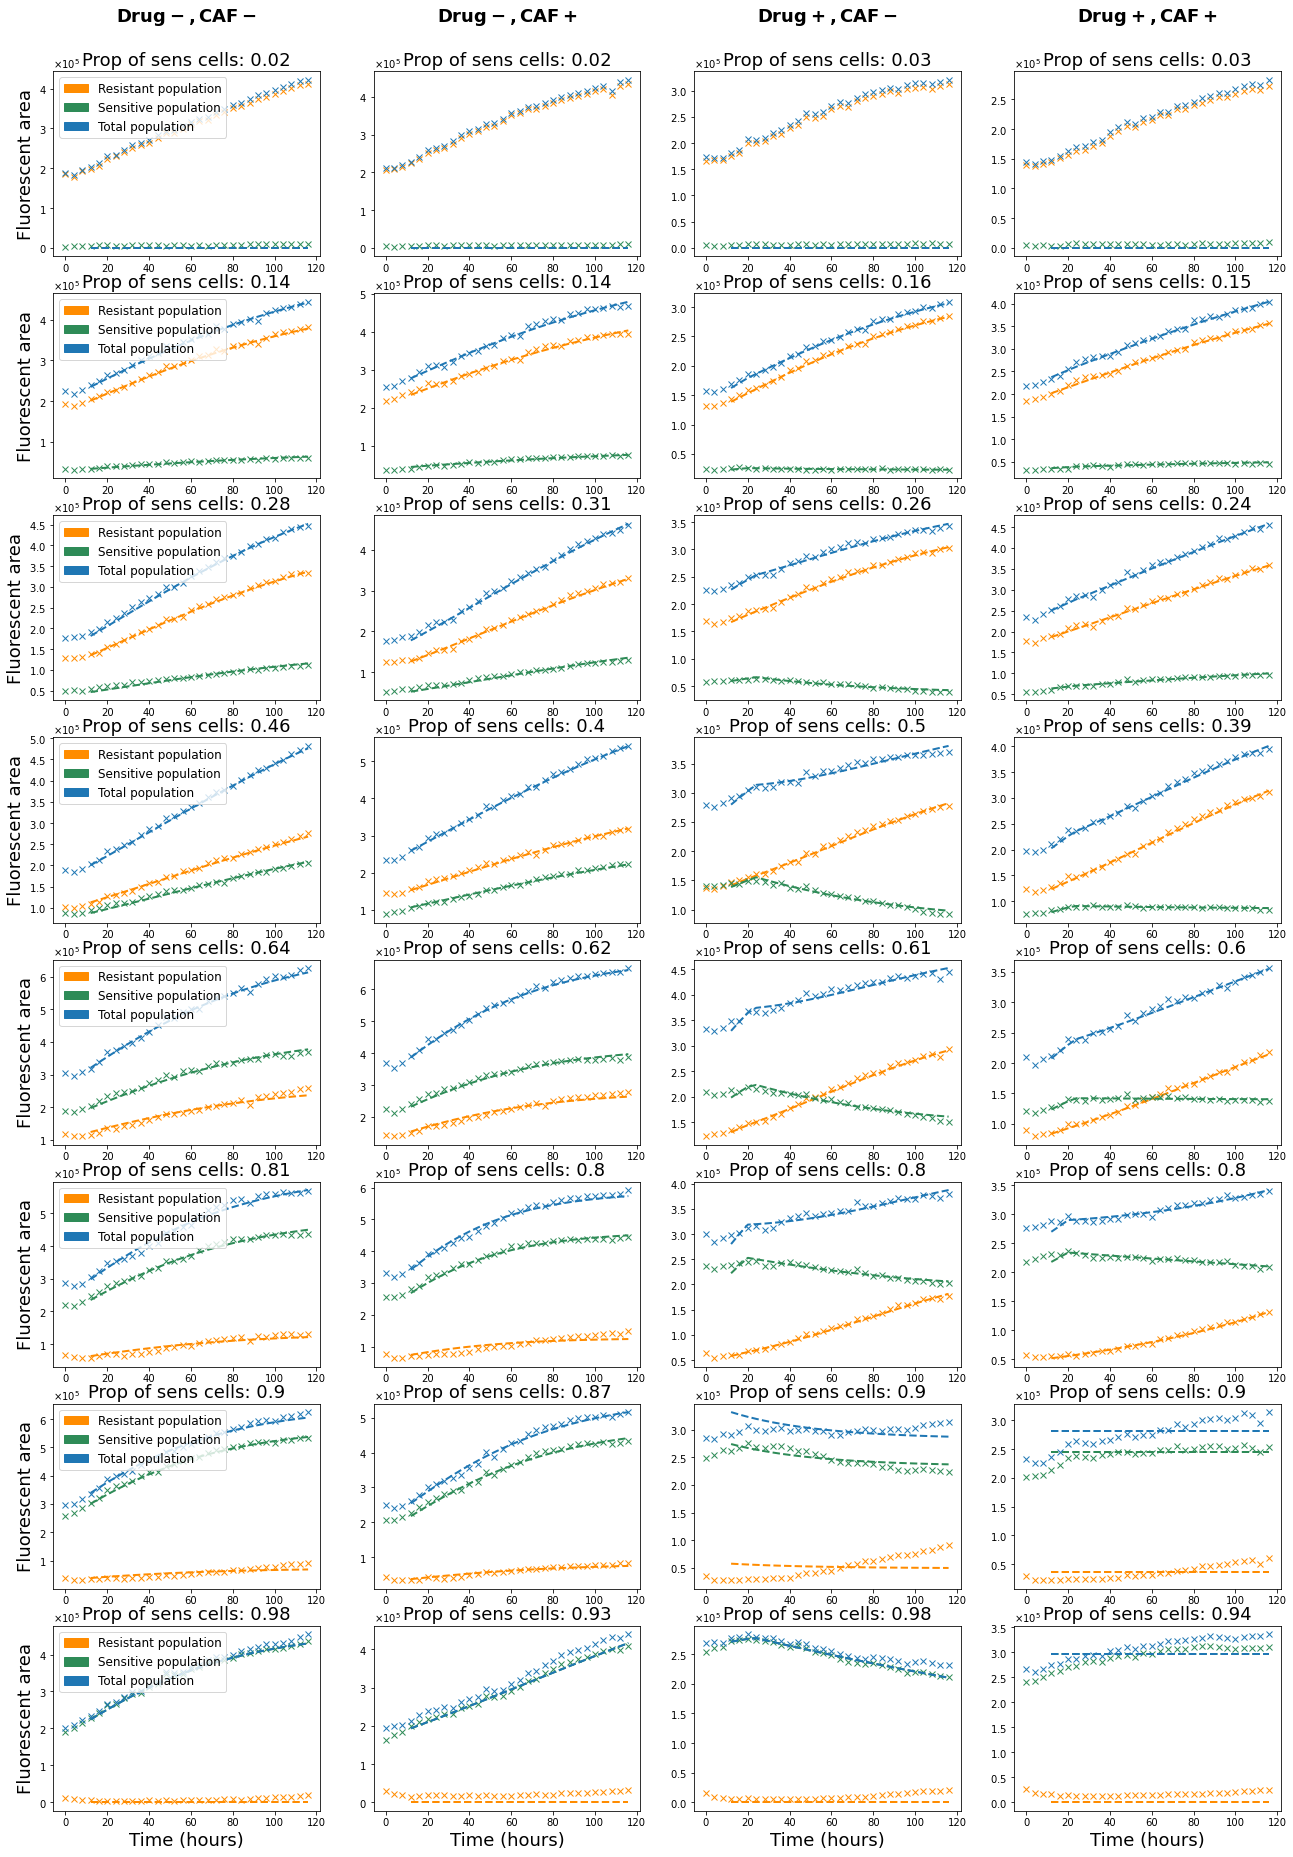

In [21]:
# Visualize dynamics
Rownames = ['Drug-, CAF-', 'Drug-, CAF+',
            'Drug+, CAF-', 'Drug+, CAF+']
t_min = 0

plt.figure(figsize=(22,32))

for k in range(0, 32):
    [i,j] = figure_indxs[k]
    ax = plt.subplot(8,4,k+1)
    ax.plot(time1, R_ind2[:, i,j], lw = 2, color = 'darkorange', linestyle='--', label = 'Resistant population');
    ax.plot(time[t_min:t_max], rlanp_t[t_min:t_max, i,j], color = 'darkorange', marker = 'x',   linestyle = 'none', fillstyle = 'none')
    ax.plot(time1, S_ind2[:, i,j], lw = 2, color = 'seagreen', linestyle='--', label = 'Sensitive population');
    ax.plot(time[t_min:t_max], glanp_t[t_min:t_max, i,j], color = 'seagreen', marker = 'x', linestyle = 'none', fillstyle = 'none')
    ax.plot(time1, R_ind2[:, i,j] + S_ind2[:, i,j] , lw = 2, color = 'tab:blue', linestyle='--', label = 'Total population');
    ax.plot(time[t_min:t_max], rlanp_t[t_min:t_max, i,j] + glanp_t[t_min:t_max, i,j], color = 'tab:blue', marker = 'x', linestyle = 'none', fillstyle = 'none')
    #ax.set_xlabel('Time (hours)')
    if k < 4:
        ax.set_title(r'$\bf{{{'+ Rownames[k]+'}}}$'+'\n\n'+'Prop of sens cells: ' + str(round(glanp_t[t_min1, i,j]/(glanp_t[t_min1, i,j] + rlanp_t[t_min1, i,j]), 2)), size = 18)
    else:
        ax.set_title('Prop of sens cells: ' + str(round(glanp_t[t_min1, i,j]/(glanp_t[t_min1, i,j] + rlanp_t[t_min1, i,j]), 2)), size = 18)
            
    if k >= 28:
        ax.set_xlabel('Time (hours)', size = 18)
    orange = matplotlib.patches.Patch(color='darkorange', label= 'Resistant population')
    blue = matplotlib.patches.Patch(color='tab:blue', label= 'Total population') 
    green = matplotlib.patches.Patch(color='seagreen', label= 'Sensitive population')  
    if (k)%4 == 0:
        ax.legend(handles=[orange, green, blue], loc = 2, fontsize = 12)
        ax.set_ylabel('Fluorescent area', size = 18)
        
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True) 
    formatter.set_powerlimits((-1,1)) 
    ax.yaxis.set_major_formatter(formatter) 

In [27]:
# Fit the model to all wells 
# with a loop over different initial parameters values
time2
K0= 1
rho0s = np.linspace(0.001, 0.01, 5)
gamma0s = np.linspace(1, 10.5, 5)
for i in range(0, np.shape(glanp_t)[1]):
    for j in range( np.shape(glanp_t)[2]):
        drug = drugV[i,j]
        fibro = fibroV[i,j]
        
        if (propP[i,j] in [0])&(drug == 0)&(fibro==0):
            p = propP[i,j]
            err_min = -1
            for rho0 in rho0s:
                for gamma0 in gamma0s:
                    try:
                        S, R, error, K, rho, gamma = FindIndParams(time2, glanp_t[t_min2:t_max, i,j]*p,
                                                               rlanp_t[t_min2:t_max,i,j], drug,
                                                               fibro, rho0, K0, gamma0, opt_init_prop = True)
                        err = mean_squared_error(glanp_t[t_min2:t_max, i,j]*p, S) + mean_squared_error(rlanp_t[t_min2:t_max, i,j], R)
                        if (err < err_min)|(err_min == -1) :
                            S_ind2[:,i, j], R_ind2[:, i, j], K_ind2[i,j], rho_ind2[i,j], gamma_ind2[i,j] = S, R, K, rho, gamma
                            err_min = err
                    except:
                        pass    
            print('j=' + str(j))


j=18
j=19
j=20
j=18
j=19
j=20


In [30]:
# Calculate MSE
props = [0.1, 0.2, 0.4, 0.6, 0.8, 0.9]
MSE_S2 = np.zeros((14,22))
MSE_R2 = np.zeros((14,22))
MSE_N2 = np.zeros((14,22))
for i in range(np.shape(glanp_t)[1]):
    for j in range( np.shape(glanp_t)[2]):
        if propP[i,j] in props:
            MSE_S2[i, j] = mean_squared_error(S_ind2[:, i,j], glanp_t[t_min1:t_max, i,j])
            MSE_R2[i, j] = mean_squared_error(R_ind2[:, i,j], rlanp_t[t_min1:t_max, i,j])
            MSE_N2[i, j] = mean_squared_error((S_ind2[:, i,j] + R_ind2[:, i,j]),
                                                 (glanp_t[t_min1:t_max, i,j] + rlanp_t[t_min1:t_max, i,j]))
            
        elif propP[i,j] in [0,1]:
            p = propP[i,j]
            MSE_S2[i, j] = mean_squared_error(S_ind2[:, i,j], glanp_t[t_min1:t_max, i,j])*p
            MSE_R2[i, j] = mean_squared_error(R_ind2[:, i,j], rlanp_t[t_min1:t_max, i,j])*(1-p)
            MSE_N2[i, j] = mean_squared_error((S_ind2[:, i,j] + R_ind2[:, i,j]),
                                                 (glanp_t[t_min1:t_max, i,j]*p + (1-p)*rlanp_t[t_min1:t_max, i,j]))
                

In [31]:
# Calculate percentage errors 
props = [0.1, 0.2, 0.4, 0.6, 0.8, 0.9]
MAPE_S2 = np.zeros((14,22))
MAPE_R2 = np.zeros((14,22))
MAPE_N2 = np.zeros((14,22))
for i in range(np.shape(glanp_t)[1]):
    for j in range( np.shape(glanp_t)[2]):
        if propP[i,j] in props:
            MAPE_S2[i, j] = mean_absolute_percentage_error(S_ind2[:, i,j], glanp_t[t_min1:t_max, i,j])
            MAPE_R2[i, j] = mean_absolute_percentage_error(R_ind2[:, i,j], rlanp_t[t_min1:t_max, i,j])
            MAPE_N2[i, j] = mean_absolute_percentage_error((S_ind2[:, i,j] + R_ind2[:, i,j]),
                                                 (glanp_t[t_min1:t_max, i,j] + rlanp_t[t_min1:t_max, i,j]))
            
        if propP[i,j] in [0, 1]:
            p = propP[i,j]
            MAPE_S2[i, j] = mean_absolute_percentage_error(S_ind2[:, i,j], glanp_t[t_min1:t_max, i,j]*p)
            MAPE_R2[i, j] = mean_absolute_percentage_error(R_ind2[:, i,j], rlanp_t[t_min1:t_max, i,j]*(1-p))
            MAPE_N2[i, j] = mean_absolute_percentage_error((S_ind2[:, i,j] + R_ind2[:, i,j]),
                                                 (glanp_t[t_min1:t_max, i,j]*p + (1-p)*rlanp_t[t_min1:t_max, i,j]))

# Analysis of parameters and error distribution

In [28]:
def GroupConditions(Drug, CAF):
    Props = np.array([])
    rho = np.array([])
    K = np.array([])
    gamma = np.array([])
                        
    MSE_ratio_S = np.array([])
    MSE_ratio_R = np.array([])
    MSE_ratio_N = np.array([])
                    
    MSE_S = np.array([])
    MSE_R = np.array([])
    MSE_N = np.array([])
                    
    MAPE_S = np.array([])
    MAPE_R = np.array([])
    MAPE_N = np.array([])
                    
    MAPE_ratio_S = np.array([])
    MAPE_ratio_R = np.array([])
    MAPE_ratio_N = np.array([])
                        
    rho_Opt = np.array([])
    K_Opt = np.array([])
    gamma_Opt = np.array([])
    
    LOG_rho = np.array([])
    LOG_K = np.array([])
    LOG_gamma = np.array([])
    
    LOG_rho_opt = np.array([])
    LOG_K_opt = np.array([])
    LOG_gamma_opt = np.array([])
    
    for i in range(np.shape(glanp_t)[1]):
        for j in range(np.shape(glanp_t)[2]):
            if propP[i, j] in props:
                if drugV[i, j] == Drug:
                    if fibroV[i, j] == CAF:
                        Props = np.append(Props, prop_real[i,j])
                        rho = np.append(rho, rho_ind1[i,j])
                        K = np.append(K, K_ind1[i,j])
                        gamma = np.append(gamma, gamma_ind1[i,j])
                        
                        MSE_ratio_S = np.append(MSE_ratio_S, [1 if (MSE_S2[i, j]==0)&(MSE_S1[i, j]==0) else MSE_S2[i,j]/MSE_S1[i, j]])
                        MSE_ratio_R = np.append(MSE_ratio_R, [1 if (MSE_R2[i, j]==0)&(MSE_R1[i, j]==0) else MSE_R2[i,j]/MSE_R1[i, j]])
                        MSE_ratio_N = np.append(MSE_ratio_N, MSE_N2[i,j]/MSE_N1[i, j])
                    
                        MSE_S = np.append(MSE_S, MSE_S1[i, j])
                        MSE_R = np.append(MSE_R, MSE_R1[i, j])
                        MSE_N = np.append(MSE_N, MSE_N1[i, j])
                    
                        MAPE_S = np.append(MAPE_S, MAPE_S1[i, j])
                        MAPE_R = np.append(MAPE_R, MAPE_R1[i, j])
                        MAPE_N = np.append(MAPE_N, MAPE_N1[i, j])
                    
                        MAPE_ratio_S = np.append(MAPE_ratio_S, [1 if (MAPE_S2[i, j]==0)&(MAPE_S1[i, j]==0) else MAPE_S2[i,j]/MAPE_S1[i, j]])
                        MAPE_ratio_R = np.append(MAPE_ratio_R, [1 if (MAPE_R2[i, j]==0)&(MAPE_R1[i, j]==0) else MAPE_R2[i,j]/MAPE_R1[i, j]])
                        MAPE_ratio_N = np.append(MAPE_ratio_N, MAPE_N2[i, j]/MAPE_N1[i, j])
                        
                        rho_Opt = np.append(rho_Opt, rho_ind2[i,j])
                        K_Opt = np.append(K_Opt, K_ind2[i,j])
                        gamma_Opt = np.append(gamma_Opt, gamma_ind2[i,j])
                        
    dic = {'props': Props,
             'rho': rho, 
             'K' : K,
             'gamma': gamma,
             'MSE_S': MSE_S,
             'MSE_R': MSE_R,
             'MSE_N': MSE_N,
             'MAPE_S': MAPE_S,
             'MAPE_R': MAPE_R,
             'MAPE_N': MAPE_N,
             'MSE_ratio_S': MSE_ratio_S,
             'MSE_ratio_R': MSE_ratio_R,
             'MSE_ratio_N': MSE_ratio_N,
             'MAPE_ratio_S': MAPE_ratio_S,
             'MAPE_ratio_R': MAPE_ratio_R,
             'MAPE_ratio_N': MAPE_ratio_N,
             'rho_Opt': rho_Opt,
             'K_Opt': K_Opt,
             'gamma_Opt': gamma_Opt}
    return dic

In [32]:
t_min = 3
props = [0, 0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 1]

Drug0CAF0 = GroupConditions(0, 0)
Drug0CAF1 = GroupConditions(0, 1)
Drug1CAF0 = GroupConditions(1, 0)
Drug1CAF1 = GroupConditions(1, 1)

In [33]:
props = [0, 0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 1]

prop_Opt00 = np.array([])
rho_Opt00 = np.array([])
K_Opt00 = np.array([])
prop_Opt01 = np.array([])
rho_Opt01 = np.array([])
K_Opt01 = np.array([])
prop_Opt10 = np.array([])
rho_Opt10 = np.array([])
K_Opt10 = np.array([])
prop_Opt11 = np.array([])
rho_Opt11 = np.array([])
K_Opt11 = np.array([])
Ninit_Opt00 = np.array([])
Ninit_Opt01 = np.array([])
Ninit_Opt10 = np.array([])
Ninit_Opt11 = np.array([])
gamma_Opt00 = np.array([])
gamma_Opt01 = np.array([])
gamma_Opt10 = np.array([])
gamma_Opt11 = np.array([])



#Percent_error_S00

for i in range(np.shape(glanp_t)[1]):
    for j in range(np.shape(glanp_t)[2]):
        if propP[i, j] in props:
            if drugV[i, j] == 0:
                if fibroV[i, j] == 0:
                    prop_Opt00 = np.append(prop_Opt00, glanp_t[t_min, i,j]/(glanp_t[t_min, i,j]+rlanp_t[t_min, i,j]))
                    rho_Opt00 = np.append(rho_Opt00, rho_ind2[i,j])
                    K_Opt00 = np.append(K_Opt00, K_ind2[i,j])
                    gamma_Opt00 = np.append(gamma_Opt00, gamma_ind2[i,j])
                else:
                    prop_Opt01 = np.append(prop_Opt01, glanp_t[t_min, i,j]/(glanp_t[t_min, i,j]+rlanp_t[t_min, i,j]))
                    rho_Opt01 = np.append(rho_Opt01, rho_ind2[i,j])
                    K_Opt01 = np.append(K_Opt01, K_ind2[i,j])
                    gamma_Opt01 = np.append(gamma_Opt01, gamma_ind2[i,j])
            else:
                if fibroV[i, j] == 0:
                    prop_Opt10 = np.append(prop_Opt10, glanp_t[t_min, i,j]/(glanp_t[t_min, i,j]+rlanp_t[t_min, i,j]))
                    rho_Opt10 = np.append(rho_Opt10, rho_ind2[i,j])
                    K_Opt10 = np.append(K_Opt10, K_ind2[i,j])
                    gamma_Opt10 = np.append(gamma_Opt10, gamma_ind2[i,j])
        
                else:
                    prop_Opt11 = np.append(prop_Opt11, glanp_t[t_min, i,j]/(glanp_t[t_min, i,j]+rlanp_t[t_min, i,j]))
                    rho_Opt11 = np.append(rho_Opt11, rho_ind2[i,j])
                    K_Opt11 = np.append(K_Opt11, K_ind2[i,j])
                    gamma_Opt11 = np.append(gamma_Opt11, gamma_ind2[i,j])
                    

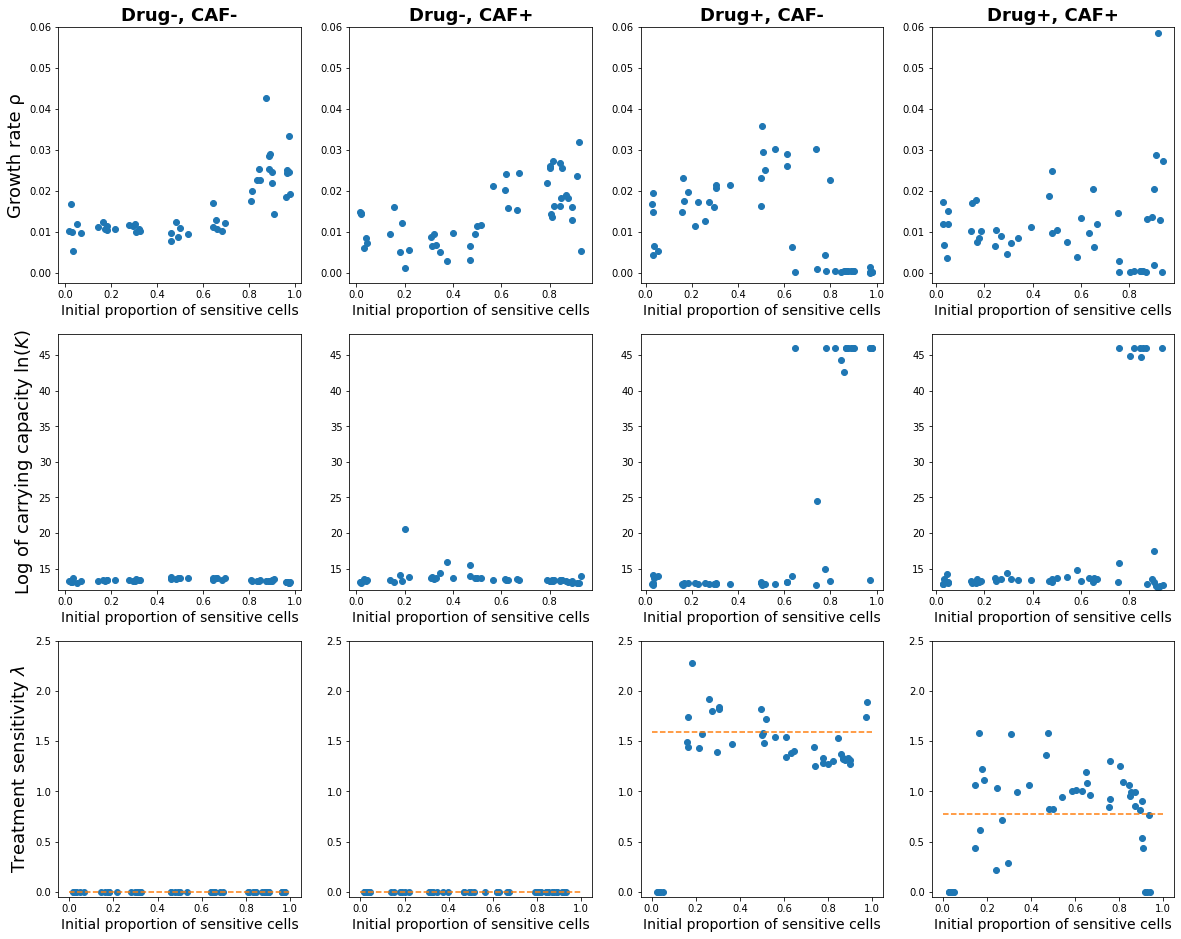

In [37]:
# Plot values of the model parameters across different experimantal conditions

fig = plt.figure(figsize=(20, 16))

for k in range(4):
    ax1 = plt.subplot(3,4,k+1)
    ax1.plot(eval('Drug'+str(int(k>=2))+'CAF'+str(k%2))['props'], eval('Drug'+str(int(k>=2))+'CAF'+str(k%2))['rho'],'o');
    ax1.set_xlabel('Initial proportion of sensitive cells', size = 14)
    if k == 0:
        ax1.set_ylabel('Growth rate ' + chr(961), size = 18)
    ax1.set_title(Rownames[k], weight = 'bold', size = 18)
    ax1.set_ylim([-0.0025, 0.06])

    ax2 = plt.subplot(3,4,k + 5)
    ax2.plot(eval('Drug'+str(int(k>=2))+'CAF'+str(k%2))['props'], np.log(eval('Drug'+str(int(k>=2))+'CAF'+str(k%2))['K']),'o');
    ax2.set_xlabel('Initial proportion of sensitive cells', size = 14)
    if k == 0:
        ax2.set_ylabel('Log of carrying capacity $\ln(K)$', size = 18)
    ax2.set_ylim([12, 48])

    ax3 = plt.subplot(3,4,k + 9)
    ax3.plot(eval('Drug'+str(int(k>=2))+'CAF'+str(k%2))['props'], eval('Drug'+str(int(k>=2))+'CAF'+str(k%2))['gamma'],'o');
    ax3.set_xlabel('Initial proportion of sensitive cells', size = 14)
    ax3.plot([0,1], [np.mean(eval('Drug'+str(int(k>=2))+'CAF'+str(k%2))['gamma']), np.mean(eval('Drug'+str(int(k>=2))+'CAF'+str(k%2))['gamma'])], '--')
    ax3.set_ylim([-0.05, 2.5])
    if k == 0:
        ax3.set_ylabel('Treatment sensitivity $\lambda$', size = 18)

plt.show()
fig.savefig('/Users/Arina/Desktop/Master Thesis/Figures for article/FIG21.jpg',
           dpi = 500, bbox_inches = "tight")
fig.savefig('/Users/Arina/Desktop/Master Thesis/Figures for PLOS/FIG3.tiff', 
            dpi=600, format="tiff", bbox_inches = "tight")

<ipython-input-29-b6926284be75>:16: RuntimeWarning: divide by zero encountered in log
  ax2.plot(eval('Drug'+str(int(k>=2))+'CAF'+str(k%2))['props'], np.log(eval('Drug'+str(int(k>=2))+'CAF'+str(k%2))['K_Opt']),'o');
<ipython-input-29-b6926284be75>:16: RuntimeWarning: divide by zero encountered in log
  ax2.plot(eval('Drug'+str(int(k>=2))+'CAF'+str(k%2))['props'], np.log(eval('Drug'+str(int(k>=2))+'CAF'+str(k%2))['K_Opt']),'o');
<ipython-input-29-b6926284be75>:16: RuntimeWarning: divide by zero encountered in log
  ax2.plot(eval('Drug'+str(int(k>=2))+'CAF'+str(k%2))['props'], np.log(eval('Drug'+str(int(k>=2))+'CAF'+str(k%2))['K_Opt']),'o');
<ipython-input-29-b6926284be75>:16: RuntimeWarning: divide by zero encountered in log
  ax2.plot(eval('Drug'+str(int(k>=2))+'CAF'+str(k%2))['props'], np.log(eval('Drug'+str(int(k>=2))+'CAF'+str(k%2))['K_Opt']),'o');


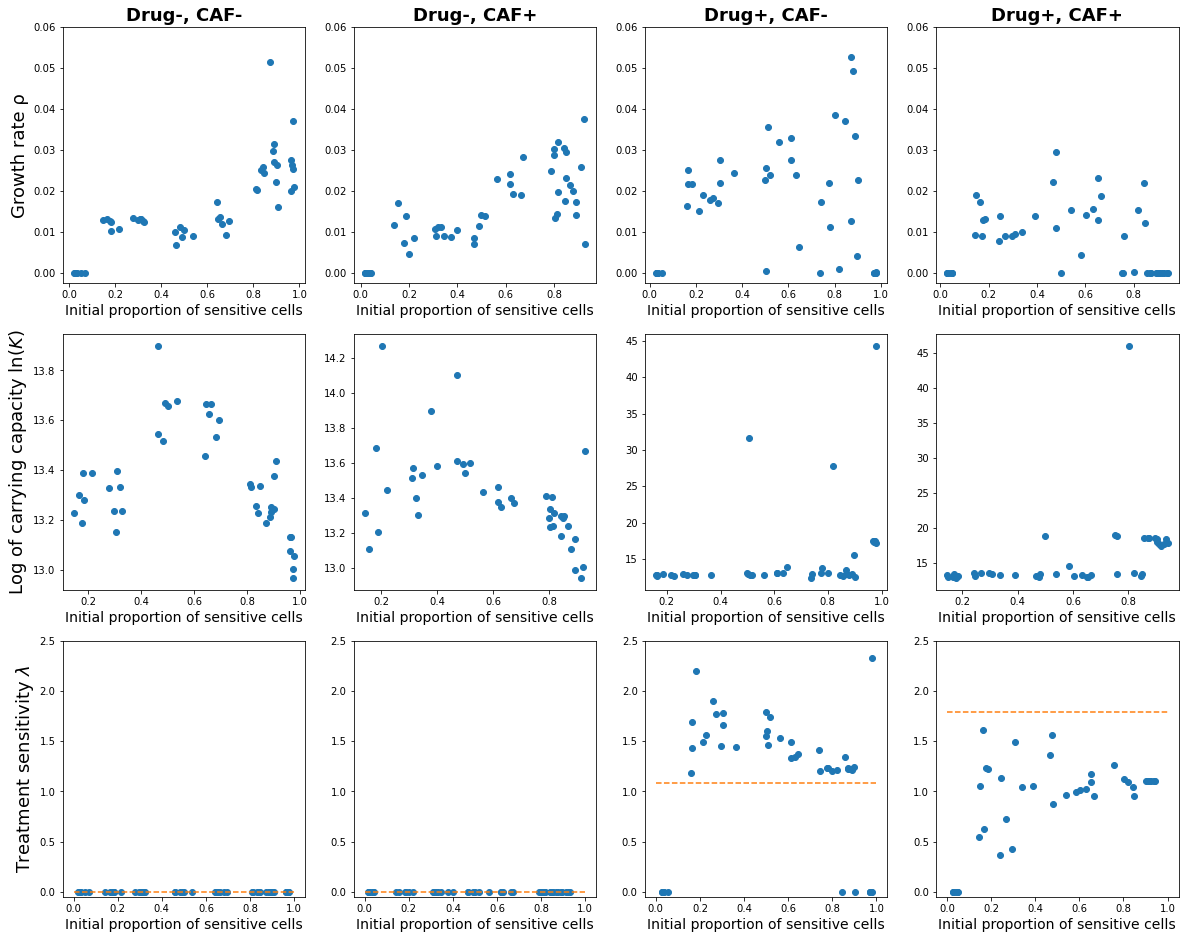

In [29]:
# Plot values of the model parameters across different experimantal conditions
# for the parameters fitted with optimozation of initial propotions

plt.figure(figsize=(20, 16))

for k in range(4):
    ax1 = plt.subplot(3,4,k+1)
    ax1.plot(eval('Drug'+str(int(k>=2))+'CAF'+str(k%2))['props'], eval('Drug'+str(int(k>=2))+'CAF'+str(k%2))['rho_Opt'],'o');
    ax1.set_xlabel('Initial proportion of sensitive cells', size = 14)
    if k == 0:
        ax1.set_ylabel('Growth rate ' + chr(961), size = 18)
    ax1.set_title(Rownames[k], weight = 'bold', size = 18)
    ax1.set_ylim([-0.0025, 0.06])

    ax2 = plt.subplot(3,4,k + 5)
    ax2.plot(eval('Drug'+str(int(k>=2))+'CAF'+str(k%2))['props'], np.log(eval('Drug'+str(int(k>=2))+'CAF'+str(k%2))['K_Opt']),'o');
    ax2.set_xlabel('Initial proportion of sensitive cells', size = 14)
    if k == 0:
        ax2.set_ylabel('Log of carrying capacity $\ln(K)$', size = 18)
    #ax2.set_ylim([12, 15])

    ax3 = plt.subplot(3,4,k + 9)
    ax3.plot(eval('Drug'+str(int(k>=2))+'CAF'+str(k%2))['props'], eval('Drug'+str(int(k>=2))+'CAF'+str(k%2))['gamma_Opt'],'o');
    ax3.set_xlabel('Initial proportion of sensitive cells', size = 14)
    ax3.plot([0,1], [np.mean(eval('Drug'+str(int(k>=2))+'CAF'+str(k%2))['gamma_Opt']), np.mean(eval('Drug'+str(int(k>=2))+'CAF'+str(k%2))['gamma_Opt'])], '--')
    ax3.set_ylim([-0.05, 2.5])
    if k == 0:
        ax3.set_ylabel('Treatment sensitivity $\lambda$', size = 18)

plt.show()

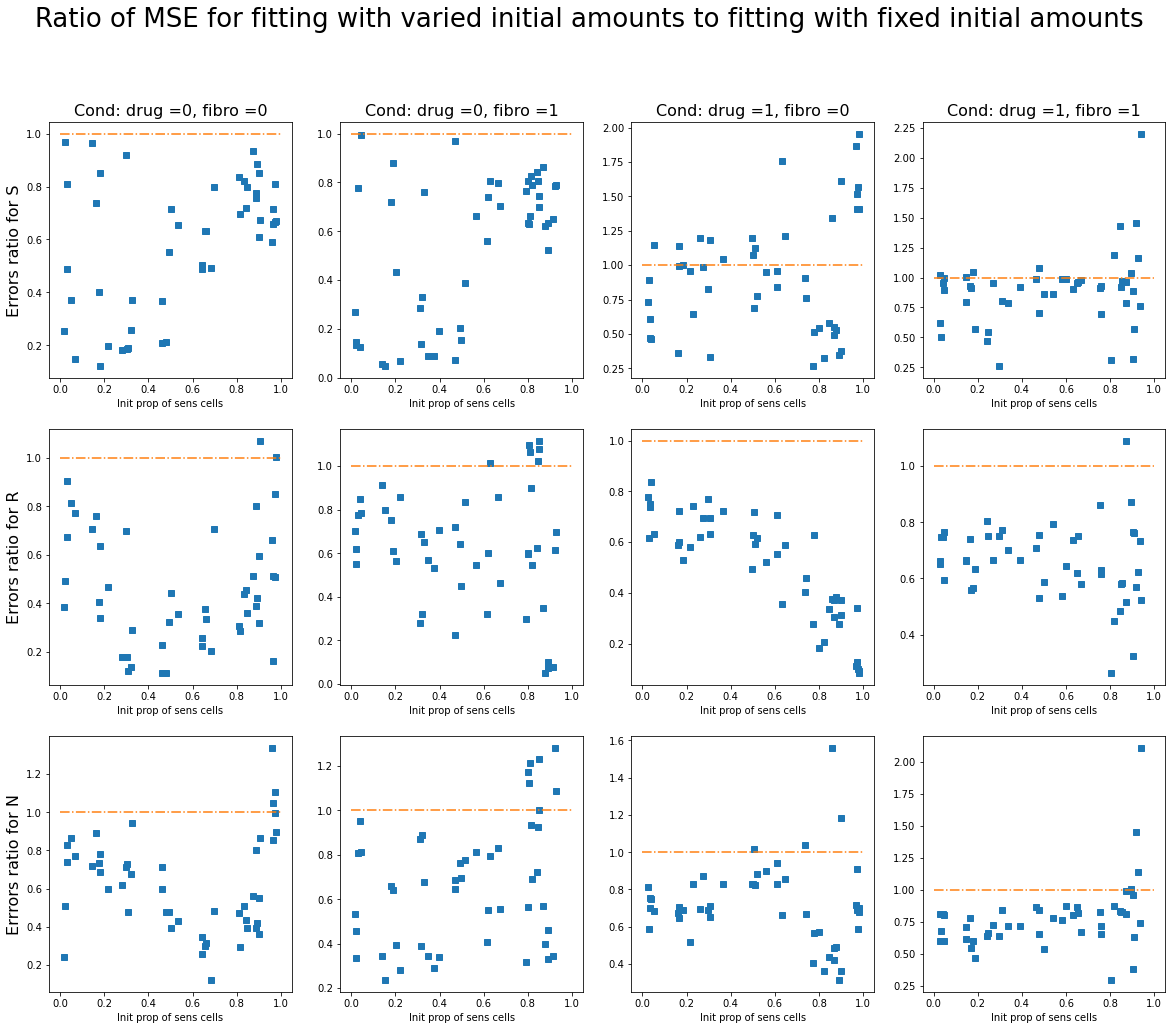

In [67]:
# Ratio of MSE of the model fits with and without optimization of initial sizes of
# sensitive and resistant populations for each welll across four experimental conditions


plt.figure(figsize=(20, 16))
code = ['00', '01', '10', '11']

plt.suptitle('Ratio of MSE for fitting with varied initial amounts to fitting with fixed initial amounts', size = 26)

for k in range(4):
    ax1 = plt.subplot(3,4,k+1)
    ax1.plot(eval('Drug'+str(int(k>=2))+'CAF'+str(k%2))['props'], eval('Drug'+str(int(k>=2))+'CAF'+str(k%2))['MSE_ratio_S'],'s')
    ax1.plot([0,1], [1, 1], '-.')
    ax1.set_xlabel('Init prop of sens cells')
    if k == 0:
        ax1.set_ylabel('Errors ratio for S', size = 16)
    ax1.set_title('Cond: drug =' + str(int(k>1)) + ', fibro =' + str(k%2), size= 16)
    #ax1.set_ylim([0, 1])

    ax2 = plt.subplot(3,4,k + 5)
    ax2.plot(eval('Drug'+str(int(k>=2))+'CAF'+str(k%2))['props'], eval('Drug'+str(int(k>=2))+'CAF'+str(k%2))['MSE_ratio_R'],'s');
    ax2.set_xlabel('Init prop of sens cells')
    ax2.plot([0,1], [1, 1], '-.')
    if k == 0:
        ax2.set_ylabel('Errors ratio for R', size = 16)
    #ax2.set_ylim([0, 1])

    ax3 = plt.subplot(3,4,k + 9)
    ax3.plot(eval('Drug'+str(int(k>=2))+'CAF'+str(k%2))['props'], eval('Drug'+str(int(k>=2))+'CAF'+str(k%2))['MSE_ratio_N'],'s');
    ax3.set_xlabel('Init prop of sens cells')
    ax3.plot([0,1], [1, 1], '-.')
    if k == 0:
        ax3.set_ylabel('Errrors ratio for N', size = 16)
    #ax3.set_ylim([0, 1])

plt.show()

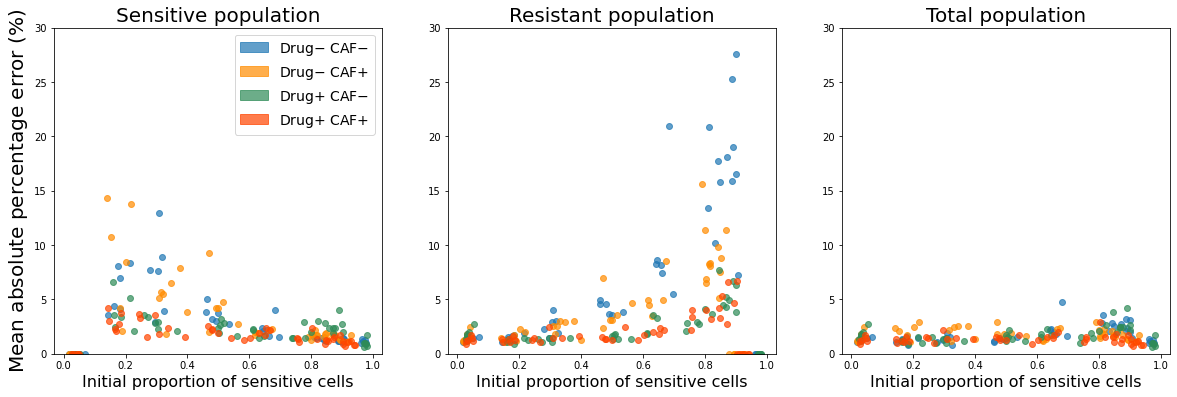

In [35]:
# Plot MAPE for fitting with fixed initial amounts for wells across four experimental conditions
fig = plt.figure(figsize=(20, 6))

#plt.suptitle('MAPE for fitting with fixed initial amounts', size = 26)
colors = ['tab:blue', 'darkorange', 'seagreen', 'orangered']

ax1 = plt.subplot(1,3,1)
for k in range(4):
    ax1.plot(eval('Drug'+str(int(k>=2))+'CAF'+str(k%2))['props'], 100*eval('Drug'+str(int(k>=2))+'CAF'+str(k%2))['MAPE_S'],'o', color = colors[k], alpha=0.7)
ax1.set_xlabel('Initial proportion of sensitive cells', size = 16)
ax1.set_ylabel('Mean absolute percentage error ($\%$)', size = 20)
ax1.set_title('Sensitive population', size = 20)
ax1.set_ylim([-0.01, 30])
blue = matplotlib.patches.Patch(color='tab:blue', alpha=0.7, label='Drug$-$ CAF$-$')
orange = matplotlib.patches.Patch(color='darkorange', alpha=0.7, label='Drug$-$ CAF$+$')
green = matplotlib.patches.Patch(color='seagreen', alpha=0.7, label='Drug$+$ CAF$-$')
red = matplotlib.patches.Patch(color='orangered', alpha=0.7, label='Drug$+$ CAF$+$')
ax1.legend(handles=[blue, orange, green , red], loc = 'best', fontsize = 14)

ax2 = plt.subplot(1,3,2)
for k in range(4):
    ax2.plot(eval('Drug'+str(int(k>=2))+'CAF'+str(k%2))['props'], 100*eval('Drug'+str(int(k>=2))+'CAF'+str(k%2))['MAPE_R'],'o', color = colors[k], alpha=0.7)
ax2.set_xlabel('Initial proportion of sensitive cells', size = 16)
ax2.set_title('Resistant population', size = 20)
ax2.set_ylim([-0.01, 30])

ax3 = plt.subplot(1,3,3)
for k in range(4):
    ax3.plot(eval('Drug'+str(int(k>=2))+'CAF'+str(k%2))['props'], 100*eval('Drug'+str(int(k>=2))+'CAF'+str(k%2))['MAPE_N'],'o', color = colors[k],alpha=0.7)
ax3.set_xlabel('Initial proportion of sensitive cells', size = 16)
ax3.set_title('Total population', size = 20)
ax3.set_ylim([-0.01, 30])

plt.show()
fig.savefig('/Users/Arina/Desktop/Master Thesis/Figures for article/FIG2.jpg',
           dpi = 500, bbox_inches = "tight")
fig.savefig('/Users/Arina/Desktop/Master Thesis/Figures for PLOS/FIG2.tiff', dpi=600, format="tiff", bbox_inches = "tight")

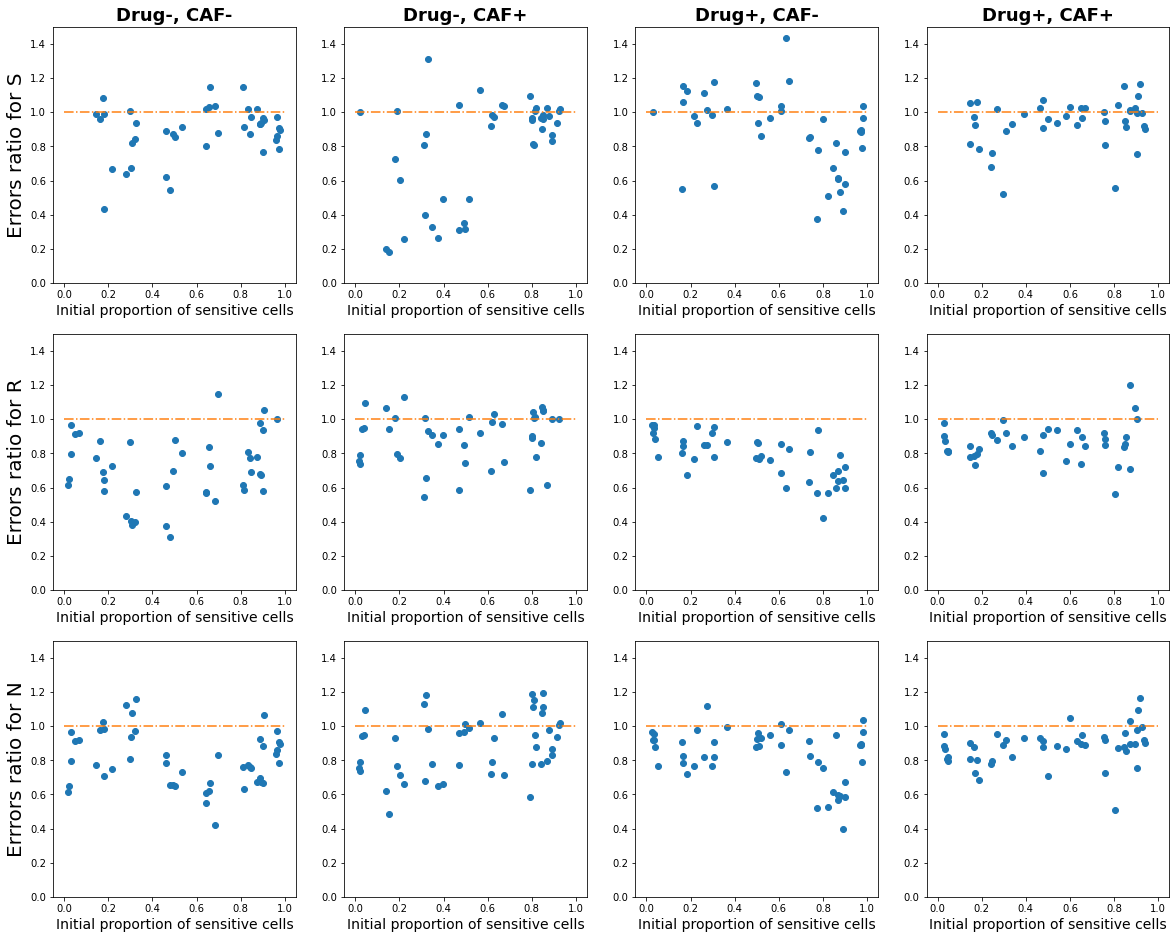

In [242]:
# Plot MAPE ratios for wells fitted with and without optimization of initial sizes
# of sensitive and resistant population
fig = plt.figure(figsize=(20, 16))

#plt.suptitle('Ratio of MAPE for fitting with varied initial amounts to fitting with fixed initial amounts', size = 26)

for k in range(4):
    ax1 = plt.subplot(3,4,k+1)
    ax1.plot(eval('Drug'+str(int(k>=2))+'CAF'+str(k%2))['props'], eval('Drug'+str(int(k>=2))+'CAF'+str(k%2))['MAPE_ratio_S'],'o')
    ax1.plot([0,1], [1, 1], '-.')
    ax1.set_xlabel('Initial proportion of sensitive cells', size = 14)
    if k == 0:
        ax1.set_ylabel('Errors ratio for S', size = 20)
    ax1.set_title(Rownames[k], weight = 'bold', size= 18)
    ax1.set_ylim([0, 1.5])

    ax2 = plt.subplot(3,4,k + 5)
    ax2.plot(eval('Drug'+str(int(k>=2))+'CAF'+str(k%2))['props'], eval('Drug'+str(int(k>=2))+'CAF'+str(k%2))['MAPE_ratio_R'],'o');
    ax2.set_xlabel('Initial proportion of sensitive cells', size = 14)
    ax2.plot([0,1], [1, 1], '-.')
    if k == 0:
        ax2.set_ylabel('Errors ratio for R', size = 20)
    ax2.set_ylim([0, 1.5])

    ax3 = plt.subplot(3,4,k + 9)
    ax3.plot(eval('Drug'+str(int(k>=2))+'CAF'+str(k%2))['props'], eval('Drug'+str(int(k>=2))+'CAF'+str(k%2))['MAPE_ratio_N'],'o');
    ax3.set_xlabel('Initial proportion of sensitive cells', size = 14)
    ax3.plot([0,1], [1, 1], '-.')
    if k == 0:
        ax3.set_ylabel('Errrors ratio for N', size = 20)
    ax3.set_ylim([0, 1.5])

fig.savefig('/Users/Arina/Desktop/Master Thesis/Figures for article/FIG8.jpg',
           dpi = 500, bbox_inches = "tight")
plt.show()

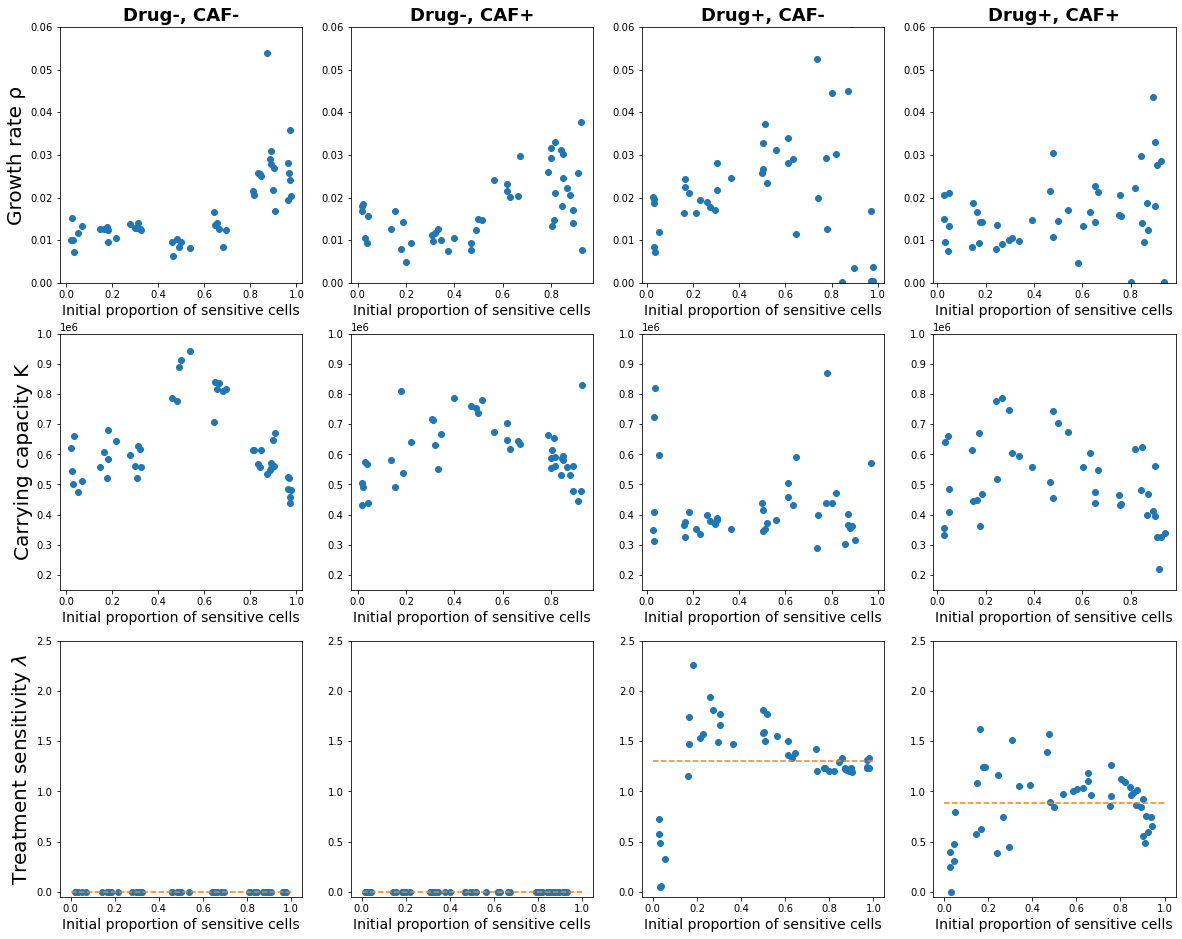

In [68]:
# Plot values of the model parameters across four experimental conditions
# fitted with optimization of initial population sizes
plt.figure(figsize=(20, 16))
code = ['00', '01', '10', '11']

for k in range(4):
    ax1 = plt.subplot(3,4,k+1)
    ax1.plot(eval('Drug'+str(int(k>=2))+'CAF'+str(k%2))['props'], eval('Drug'+str(int(k>=2))+'CAF'+str(k%2))['rho_Opt'],'o');
    ax1.set_xlabel('Initial proportion of sensitive cells', size = 14)
    if k == 0:
        ax1.set_ylabel('Growth rate '+chr(961), size = 20)
    ax1.set_title(Rownames[k], weight = 'bold', size = 18)
    ax1.set_ylim([0, 0.06])

    ax2 = plt.subplot(3,4,k + 5)
    ax2.plot(eval('Drug'+str(int(k>=2))+'CAF'+str(k%2))['props'], eval('Drug'+str(int(k>=2))+'CAF'+str(k%2))['K_Opt'],'o');
    ax2.set_xlabel('Initial proportion of sensitive cells', size =14)
    if k == 0:
        ax2.set_ylabel('Carrying capacity K', size = 20)
    ax2.set_ylim([1.5*10**5, 10**6])

    ax3 = plt.subplot(3,4,k + 9)
    ax3.plot(eval('Drug'+str(int(k>=2))+'CAF'+str(k%2))['props'], eval('Drug'+str(int(k>=2))+'CAF'+str(k%2))['gamma_Opt'],'o');
    ax3.set_xlabel('Initial proportion of sensitive cells', size = 14)
    ax3.plot([0,1], [np.mean(eval('Drug'+str(int(k>=2))+'CAF'+str(k%2))['gamma_Opt']), np.mean(eval('Drug'+str(int(k>=2))+'CAF'+str(k%2))['gamma_Opt'])], '--')
    ax3.set_ylim([-0.05, 2.5])
    if k == 0:
        ax3.set_ylabel('Treatment sensitivity $\lambda$', size = 20)

plt.show()


# t-test

In [243]:
stats.ttest_ind(Drug1CAF0['gamma'], Drug1CAF1['gamma'], equal_var = False)

Ttest_indResult(statistic=5.441482217996752, pvalue=5.253087278117136e-07)

In [245]:
stats.ttest_ind(Drug1CAF0['K'], Drug1CAF1['K'], equal_var = False)

Ttest_indResult(statistic=2.3231427025083473, pvalue=0.02258466845614229)

In [244]:
stats.ttest_ind(Drug1CAF0['gamma_Opt'], Drug1CAF1['gamma_Opt'], equal_var = False)

Ttest_indResult(statistic=1.000302143509633, pvalue=0.32228668375674907)

In [246]:
stats.ttest_ind(Drug1CAF0['K_Opt'], Drug1CAF0['gamma'], equal_var = False)

Ttest_indResult(statistic=2.437772937084848, pvalue=0.01861471341182562)